# Fit model atmosphere to exoplanet spectrum

In [ ]:
#@title Imports

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os


## Get planet spectrum

In [ ]:
! wget https://share.phys.ethz.ch/~ipa/exoplanet_lecture_FS24/FIREFLy_transit_spec.h5

--2025-05-22 08:58:02--  https://share.phys.ethz.ch/~ipa/exoplanet_lecture_FS24/FIREFLy_transit_spec.h5
Resolving share.phys.ethz.ch (share.phys.ethz.ch)... 129.132.80.27, 2001:67c:10ec:3dc4::39
Connecting to share.phys.ethz.ch (share.phys.ethz.ch)|129.132.80.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7016 (6.9K)
Saving to: ‘FIREFLy_transit_spec.h5.1’

FIREFLy_transit_spe 100%[===================>]   6.85K  --.-KB/s    in 0s      

2025-05-22 08:58:03 (1.60 GB/s) - ‘FIREFLy_transit_spec.h5.1’ saved [7016/7016]



In [ ]:
# load data
with h5py.File("FIREFLy_transit_spec.h5", "r") as f:
    print("Keys: %s" % f.keys())
    wav = f['wavelength'][()]
    transit_depth = f['transit_depth'][()]
    transit_depth_uncertainty = f['transit_depth_uncertainty'][()]

Keys: <KeysViewHDF5 ['transit_depth', 'transit_depth_uncertainty', 'wavelength']>


<ErrorbarContainer object of 3 artists>

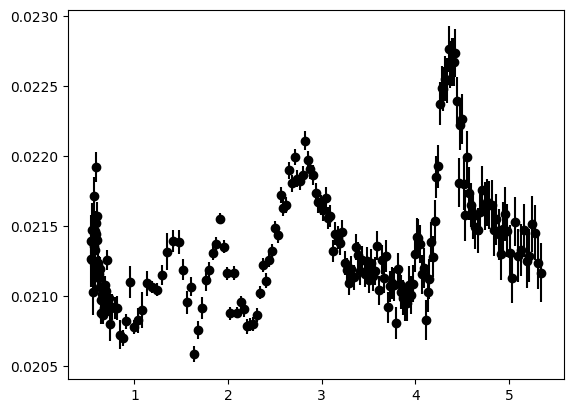

In [ ]:
plt.figure()
plt.errorbar(wav, transit_depth, yerr=transit_depth_uncertainty, fmt="o", color="black")

In [ ]:
#@title Install petitRADTRANS
!pip install meson-python ninja
!pip install petitRADTRANS --no-build-isolation

## Import petitRADTRANS package

In [ ]:
import petitRADTRANS
from petitRADTRANS.radtrans import Radtrans
from petitRADTRANS import physical_constants as cst

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from petitRADTRANS.config.configuration import petitradtrans_config_parser

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Define input folder for opacities
# os.mkdir("input_data")

from google.colab import drive
drive.mount('/content/drive')

# set folder in petitRADTRANS config file
petitradtrans_config_parser.set_input_data_path('./drive/MyDrive/')
#petitradtrans_config_parser.set_input_data_path('./')

# # if you are using your google drive to access the input_data folder
# # first mount your drive
# from google.colab import drive
# drive.mount('/content/drive')
# # set the folder path to
# petitradtrans_config_parser.set_input_data_path('./drive/MyDrive/')

## Initialize Radtrans Object
For this opacity files need to be loaded from the input_data folder.


In [ ]:
# from selenium import webdriver
# from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.chrome.service import Service

In [ ]:
# Install necessary packages
# !apt update
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin
# !pip install selenium

# # Configure Selenium
# from selenium import webdriver
# from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.chrome.service import Service

# chrome_options = Options()
# chrome_options.add_argument('--headless')
# chrome_options.add_argument('--no-sandbox')
# chrome_options.add_argument('--disable-dev-shm-usage')

# driver = webdriver.Chrome(options=chrome_options)

# # Test
# driver.get('https://www.google.com')
# print(driver.title)

#Load opcities
radtrans = Radtrans(
pressures=np.logspace(-6, 2, 100),
line_species=[
    'H2O',
    'CO-NatAbund',
    'CH4',
    'CO2',
    'Na',
    'K'
],
rayleigh_species=['H2', 'He'],
gas_continuum_contributors=['H2-H2', 'H2-He'],
wavelength_boundaries=[0.3, 6]
)

# driver.quit()

### Get planet data

In [ ]:
from petitRADTRANS.planet import Planet

In [ ]:
planet = Planet.get('WASP-39 b')

In [ ]:
# Display the planet radius and its uncertainties
print(
    f"{planet.name}'s radius: {planet.radius * 1e-5:.0f} "
    f"+{planet.radius_error_upper * 1e-5:.0f} / {planet.radius_error_lower * 1e-5:.0f} km"
)

## Calculate first atmosphere

In [ ]:
temperatures = 1170 * np.ones_like(radtrans.pressures) # note that radtrans.pressures is in cgs units now, multiply by 1e-6 to get bars
mass_fractions = {
    'H2': 0.74 * np.ones(temperatures.size),
    'He': 0.24 * np.ones(temperatures.size),
    'H2O': 5e-5 * np.ones(temperatures.size),
    'CO-NatAbund': 1e-9 * np.ones(temperatures.size),
    'CO2': 1e-5 * np.ones(temperatures.size),
    'CH4': 1e-7 * np.ones(temperatures.size),
    'Na': 1e-4 * np.ones(temperatures.size),
    'K': 1e-6 * np.ones(temperatures.size)
}

#  2.33 is a typical value for H2-He dominated atmospheres
mean_molar_masses = 2.33 * np.ones(temperatures.size)

In [ ]:
plt.figure()
plt.semilogy(temperatures, radtrans.pressures)
plt.ylabel("pressure")
plt.xlabel("temperature")

In [ ]:
wavelengths, transit_radii, _ = radtrans.calculate_transit_radii(
    temperatures=temperatures,
    mass_fractions=mass_fractions,
    mean_molar_masses=mean_molar_masses,
    reference_gravity=planet.reference_gravity,
    planet_radius=planet.radius,
    reference_pressure=planet.reference_pressure
)

## Visualise model atmosphere

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths * 1e4, (transit_radii/(1.02*planet.star_radius))**2)
ax.errorbar(wav, transit_depth, yerr=transit_depth_uncertainty, fmt="o", color="black")
#ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit depth')



## Test molecules one by one

In [ ]:
# eg H2O

radtrans = Radtrans(
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O',
         ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    wavelength_boundaries=[0.3, 6]
)

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.errorbar(wav, transit_depth, yerr=transit_depth_uncertainty, fmt="o", color="black")
for abund in [1e-4, 1e-3, 1e-2, 1e-1]:
    temperatures = 1170 * np.ones_like(radtrans.pressures) # note that radtrans.pressures is in cgs units now, multiply by 1e-6 to get bars
    mass_fractions = {
        'H2': 0.74 * np.ones(temperatures.size),
        'He': 0.24 * np.ones(temperatures.size),
        'H2O': abund * np.ones(temperatures.size),
    }

    #  2.33 is a typical value for H2-He dominated atmospheres
    mean_molar_masses = 2.33 * np.ones(temperatures.size)
    wavelengths, transit_radii, _ = radtrans.calculate_transit_radii(
    temperatures=temperatures,
    mass_fractions=mass_fractions,
    mean_molar_masses=mean_molar_masses,
    reference_gravity=planet.reference_gravity,
    planet_radius=planet.radius,
    reference_pressure=planet.reference_pressure
    )


    ax.plot(wavelengths * 1e4, (transit_radii/(1.02*planet.star_radius))**2, label=abund)

ax.legend()
#ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit depth')

In [ ]:
radtrans = Radtrans(
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O',
        'CO2'
         ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    wavelength_boundaries=[0.3, 6]
)

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.errorbar(wav, transit_depth, yerr=transit_depth_uncertainty, fmt="o", color="black")
for abund in [1e-6, 1e-5, 5e-5, 1e-4]:
    temperatures = 1170 * np.ones_like(radtrans.pressures) # note that radtrans.pressures is in cgs units now, multiply by 1e-6 to get bars
    mass_fractions = {
        'H2': 0.74 * np.ones(temperatures.size),
        'He': 0.24 * np.ones(temperatures.size),
        'H2O': 1e-4 * np.ones(temperatures.size),
        'CO2': abund * np.ones(temperatures.size)
    }

    #  2.33 is a typical value for H2-He dominated atmospheres
    mean_molar_masses = 2.33 * np.ones(temperatures.size)
    wavelengths, transit_radii, _ = radtrans.calculate_transit_radii(
    temperatures=temperatures,
    mass_fractions=mass_fractions,
    mean_molar_masses=mean_molar_masses,
    reference_gravity=planet.reference_gravity,
    planet_radius=planet.radius,
    reference_pressure=planet.reference_pressure
    )


    ax.plot(wavelengths * 1e4, (transit_radii/(1.02*planet.star_radius))**2, label=abund)

ax.legend()
#ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit depth')

## More realistic PT profile

In [ ]:
from petitRADTRANS.physics import temperature_profile_function_guillot_global

In [ ]:
pressures_bar = radtrans.pressures * 1e-6 # cgs to bar
infrared_mean_opacity = 0.01
gamma = 0.4
intrinsic_temperature = 200
equilibrium_temperature = 1200

temperatures = temperature_profile_function_guillot_global(
    pressures=pressures_bar,
    infrared_mean_opacity=infrared_mean_opacity,
    gamma=gamma,
    gravities=planet.reference_gravity,
    intrinsic_temperature=intrinsic_temperature,
    equilibrium_temperature=equilibrium_temperature
)

In [ ]:
# plot PT profile
plt.figure()
plt.semilogy(temperatures, radtrans.pressures)
plt.ylabel("pressure")
plt.xlabel("temperature")

In [ ]:
mass_fractions = {
    'H2': 0.74 * np.ones(temperatures.size),
    'He': 0.24 * np.ones(temperatures.size),
    'H2O': 1e-2 * np.ones(temperatures.size),
    'CO-NatAbund': 1e-4 * np.ones(temperatures.size),
    'CO2': 1e-4 * np.ones(temperatures.size),
    'CH4': 1e-15 * np.ones(temperatures.size),
    'Na': 1e-8 * np.ones(temperatures.size),
    'K': 1e-6 * np.ones(temperatures.size)
}

#  2.33 is a typical value for H2-He dominated atmospheres
mean_molar_masses = 2.33 * np.ones(temperatures.size)

In [ ]:
power_law_opacity_350nm = 0.008
power_law_opacity_coefficient = -1.

wavelengths, transit_radii, _ = radtrans.calculate_transit_radii(
    temperatures=temperatures,
    mass_fractions=mass_fractions,
    mean_molar_masses=mean_molar_masses,
    reference_gravity=planet.reference_gravity,
    planet_radius=planet.radius,
    reference_pressure=planet.reference_pressure,
    power_law_opacity_350nm=power_law_opacity_350nm,
    power_law_opacity_coefficient=power_law_opacity_coefficient
)

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths * 1e4, (transit_radii/(1.05*planet.star_radius))**2)
ax.errorbar(wav, transit_depth, yerr=transit_depth_uncertainty, fmt="o", color="black")
#ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit depth')